In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cv2;

%matplotlib inline

# Automatic Panorama Stitching

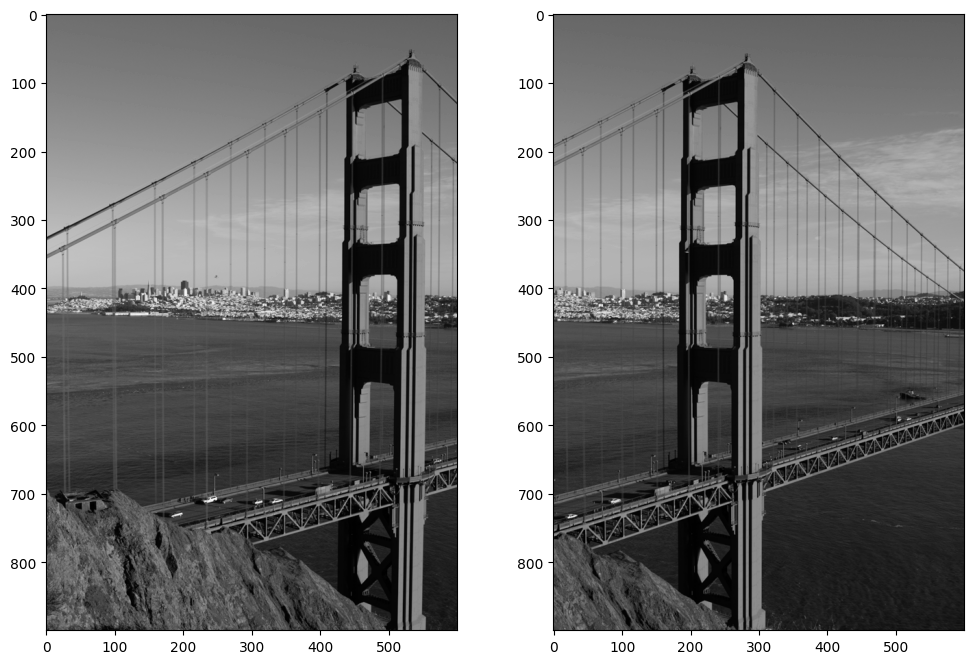

In [2]:
imgL = cv2.imread('goldengate/goldengate-02.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('goldengate/goldengate-03.png', cv2.IMREAD_GRAYSCALE)
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(imgL, cmap='gray')
axes[1].imshow(imgR, cmap='gray');

In [3]:
def fit_homography(img_source, img_target, n_features=3000, contrast_threshold=0.02, distance_ratio=0.8):
    n_features = 3000
    sift = cv2.SIFT_create(n_features)
    sift.setContrastThreshold(contrast_threshold)
    
    keys_s, desc_s = sift.detectAndCompute(img_source, None)
    keys_t, desc_t = sift.detectAndCompute(img_target, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc_s, desc_t, k=2)
    
    goodMatches = []
    for m, n in matches:
        if m.distance < distance_ratio*n.distance:
            goodMatches.append(m)
    
    pts_s = np.float32([keys_s[m.queryIdx].pt for m in goodMatches])
    pts_t = np.float32([keys_t[m.trainIdx].pt for m in goodMatches])
    H, mask = cv2.findHomography(pts_s, pts_t, cv2.USAC_ACCURATE)
    
    mask = mask.ravel()
    n_inliers = np.sum(mask)

    inlier_corr = np.empty((n_inliers, 4), dtype=np.float64)
    inlier_corr[:, :2] = pts_s[mask==1, :]
    inlier_corr[:, 2:] = pts_t[mask==1, :]

    distances = np.array([m.distance for m in goodMatches])
    inlier_dist = np.array(distances[mask==1], dtype = np.float64)
    
    return H, inlier_corr, inlier_dist

In [4]:
H, inlier_corr, inlier_dist = fit_homography(imgR, imgL)

In [5]:
def draw_matches(img_source, img_target, inlier_corr, inlier_dist):
    hs, ws = img_source.shape
    ht, wt = img_target.shape
    combined = np.zeros((np.max([hs, ht]), ws + wt, 4), np.uint8)
    combined[:hs, :ws, :3] = np.expand_dims(img_source, 2)
    combined[:ht, ws:, :3] = np.expand_dims(img_target, 2)
    combined[:, :, 3] = 255
    max_dist = np.max(inlier_dist)
    color0 = np.array([[255, 0, 0, 255]])
    color1 = np.array([[0, 0, 255, 255]])
    alphas = np.power(np.array([inlier_dist / max_dist]), 0.7)
    colors = alphas.T @ color0 + (1.0 - alphas.T) @ color1
    colors = np.clip(colors, 0, 255).astype(np.uint8)
    for corr, dist, color in zip(inlier_corr, inlier_dist, colors):
        color = color.tolist()
        pt0 = int(corr[0]), int(corr[1])
        pt1 = int(corr[2] + ws), int(corr[3])
        cv2.drawMarker(combined, pt0, color, cv2.MARKER_DIAMOND, 5)
        cv2.drawMarker(combined, pt1, color, cv2.MARKER_DIAMOND, 5)
        #cv2.line(combined, pt0, pt1, color, lineType=cv2.LINE_AA)
    return combined

True

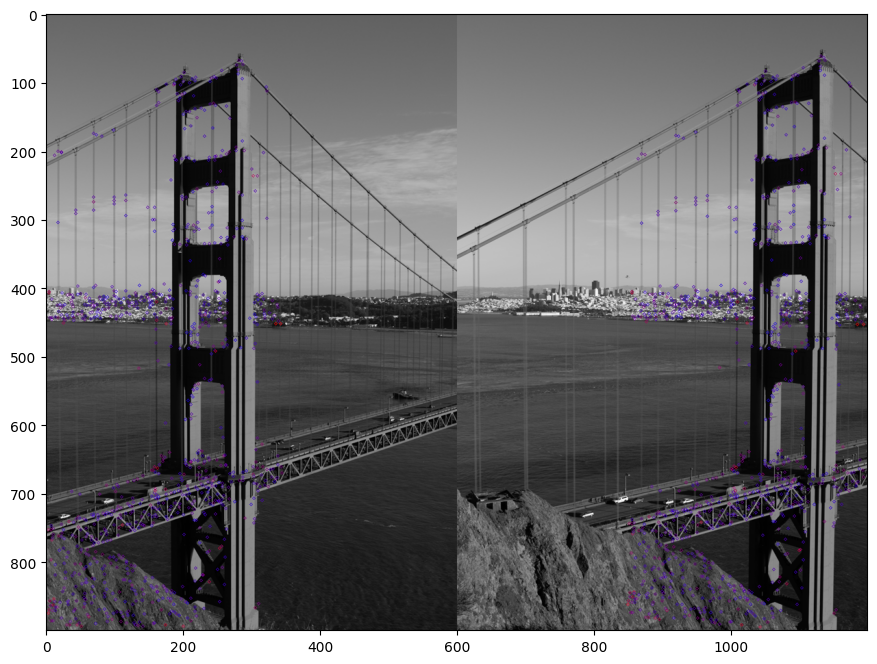

In [6]:
combined = draw_matches(imgR, imgL, inlier_corr, inlier_dist)
fig, axis = plt.subplots(figsize=(12,8))
axis.imshow(combined)
cv2.imwrite('matches.png', cv2.cvtColor(combined, cv2.COLOR_RGBA2BGRA))

In [7]:
def calculate_mosaic_geometry(img_source, img_target, H):
    hs, ws = img_source.shape
    ht, wt = img_target.shape
    corners = H @ np.array([[0.0,  ws,  ws, 0.0],
                            [0.0, 0.0,  hs,  hs],
                            [1.0, 1.0, 1.0, 1.0]])
    corners = corners / corners[2, :]
    corners = np.hstack([corners[:2, :], [[0.0,  wt, wt, 0.0],
                                          [0.0, 0.0, ht,  ht]]])
    x_min, y_min = np.min(corners, axis=1)
    x_max, y_max = np.max(corners, axis=1)
    hm = int(y_max - y_min + 0.5)
    wm = int(x_max - x_min + 0.5)
    
    H_m2t = np.array([[1.0, 0.0, x_min],
                      [0.0, 1.0, y_min],
                      [0.0, 0.0, 1.0]])
    return (hm, wm), H_m2t

In [8]:
mosaic_size, H_m2t = calculate_mosaic_geometry(imgR, imgL, H)

In [9]:
def warp(mosaic_size, img, H_m2i, sigma=0.8):
    mosaic = np.zeros(mosaic_size, dtype=np.uint8)
    weights = np.zeros(mosaic_size, dtype=np.float32)

    hm, wm = mosaic_size
    hi, wi = img.shape
    for y in range(hm):
        for x in range(wm):
            s = H_m2i[2][0]*x + H_m2i[2][1]*y + H_m2i[2][2]
            xi = (H_m2i[0][0]*x + H_m2i[0][1]*y + H_m2i[0][2]) / s
            yi = (H_m2i[1][0]*x + H_m2i[1][1]*y + H_m2i[1][2]) / s
            
            if xi < 0 or yi < 0 or xi >= (wi - 1) or yi >= (hi - 1):
                continue
                
            x00 = int(xi)
            y00 = int(yi)
            alpha = xi - x00
            beta = yi - y00
            
            I00 = img[y00, x00]
            I01 = img[y00, x00 + 1]
            I10 = img[y00 + 1, x00]
            I11 = img[y00 + 1, x00 + 1]

            I = (1.0 - alpha) * (1.0 - beta) * I00 \
                + alpha * (1 - beta) * I01 \
                + (1 - alpha) * beta * I10 \
                + alpha * beta * I11
            I = np.min([np.max([I, 0]), 255])
            mosaic[y, x] = I

            dx = 2.0 * xi / wi - 1.0
            dy = 2.0 * yi / hi - 1.0
            wx = np.exp(-0.5 * dx**2 / sigma**2)
            wy = np.exp(-0.5 * dy**2 / sigma**2)
            weights[y, x] = wx * wy
            
    return mosaic, weights

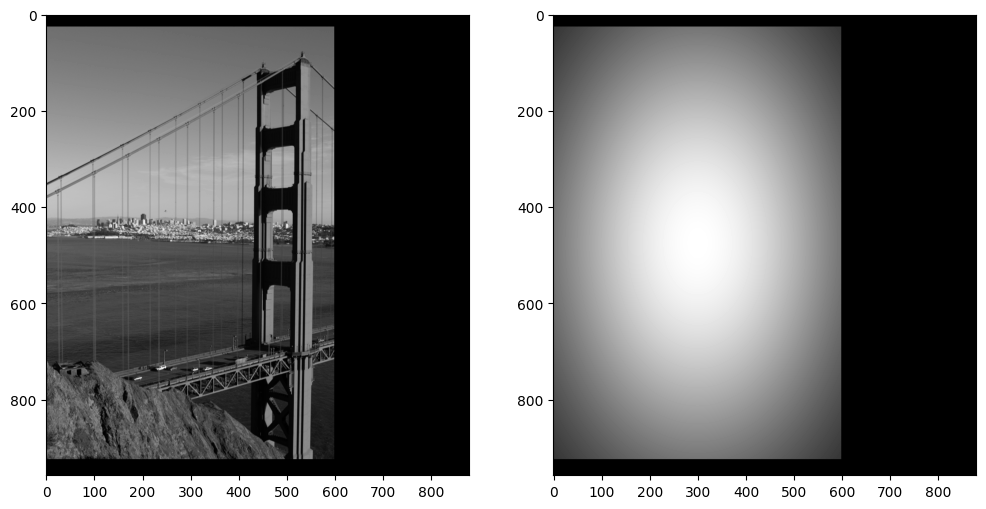

In [10]:
mosaic_t, w_t = warp(mosaic_size, imgL, H_m2t)
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(mosaic_t, cmap='gray')
axes[1].imshow(w_t, cmap='gray')

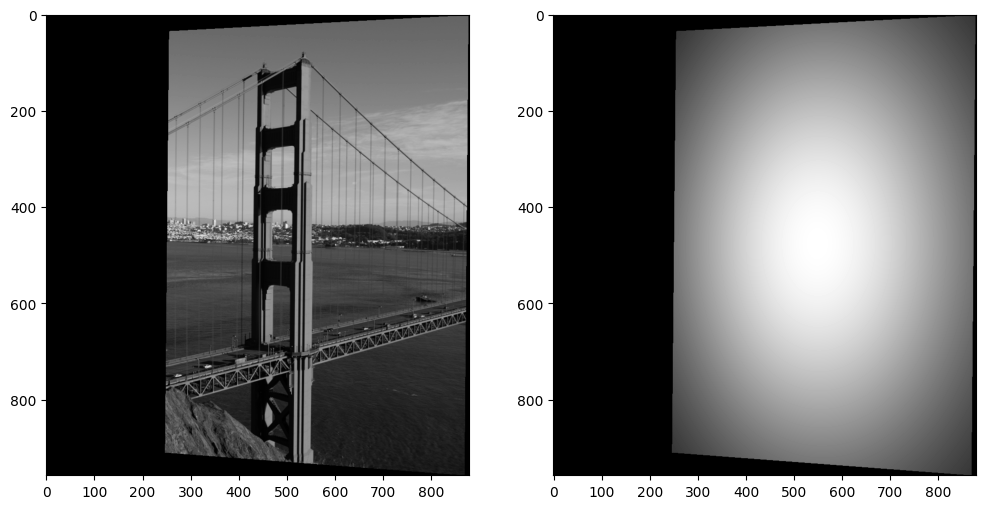

In [11]:
H_t2s = np.linalg.inv(H)
H_m2s = H_m2t @ H_t2s
mosaic_s, w_s = warp(mosaic_size, imgR, H_m2s)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(mosaic_s, cmap='gray')
axes[1].imshow(w_s, cmap='gray')

In [12]:
def blend(img0, w0, img1, w1):
    height, width = img0.shape
    assert height == img1.shape[0] and width == img1.shape[1]
    assert height == w0.shape[0]   and width == w0.shape[1]
    assert height == w1.shape[0]   and width == w1.shape[1]
    
    cw0 = w0 / (w0 + w1 + 1e-5)
    composite_img = img0 * cw0 + img1 * (1.0 - cw0)
    composite_img = composite_img.clip(0, 255).astype(np.uint8)
    
    return composite_img

In [13]:
def stitch(img_source, img_target, H):
    sigma_s = 0.3
    sigma_t = 0.3
    
    mosaic_size, H_m2t = calculate_mosaic_geometry(img_source, img_target, H)
    
    mosaic_t, w_t = warp(mosaic_size, img_target, H_m2t, sigma_t)

    H_t2s = np.linalg.inv(H)
    H_m2s = H_m2t @ H_t2s
    mosaic_s, w_s = warp(mosaic_size, img_source, H_m2s, sigma_s)
    
    mosaic = blend(mosaic_t, w_t, mosaic_s, w_s)
    return mosaic

In [14]:
mosaic = stitch(imgR, imgL, H)

True

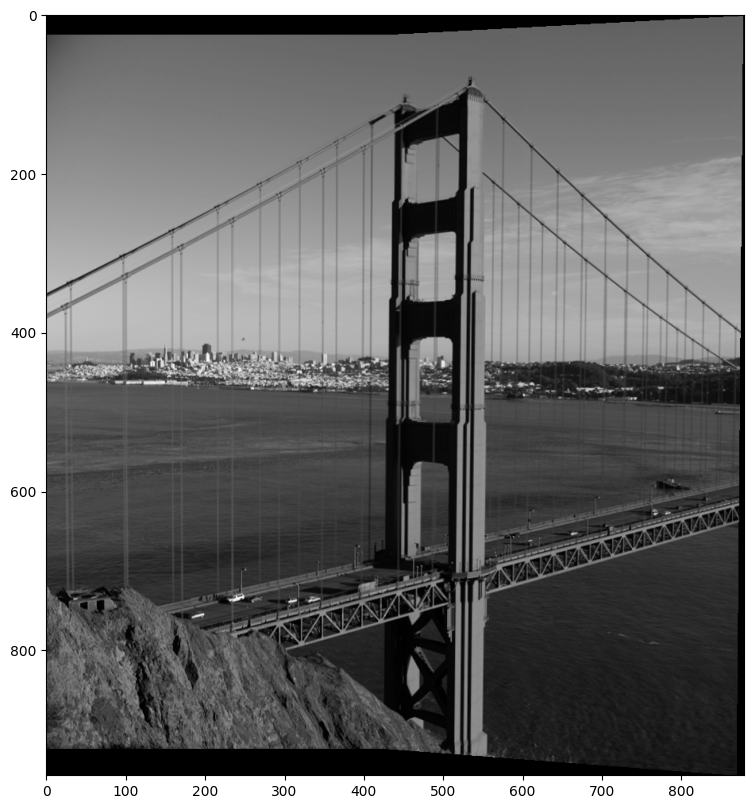

In [15]:
fig, axis = plt.subplots(figsize=(9,16))
axis.imshow(mosaic, cmap='gray');
cv2.imwrite('mosaic.png', mosaic)

# Multi-Image Stitching

In [16]:
img0 = cv2.imread('goldengate/goldengate-00.png', cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('goldengate/goldengate-01.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('goldengate/goldengate-02.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('goldengate/goldengate-03.png', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('goldengate/goldengate-04.png', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('goldengate/goldengate-05.png', cv2.IMREAD_GRAYSCALE)

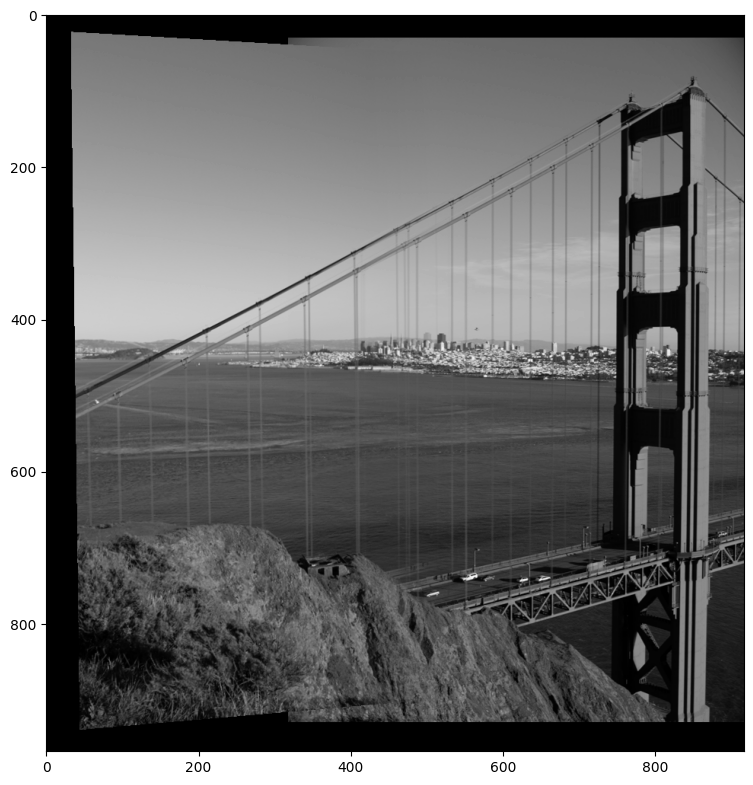

In [17]:
H, inlier_corr, inlier_dist = fit_homography(img1, img2)
mosaic21 = stitch(img1, img2, H)
fig, axis = plt.subplots(figsize=(9,16))
axis.imshow(mosaic21, cmap='gray');

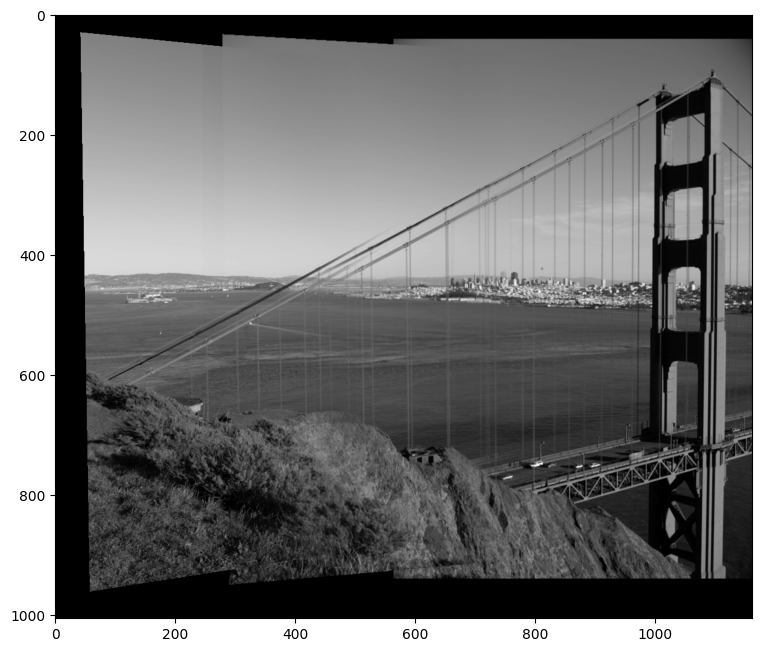

In [18]:
H, inlier_corr, inlier_dist = fit_homography(img0, mosaic21)
mosaic012 = stitch(img0, mosaic21, H)
fig, axis = plt.subplots(figsize=(9,16))
axis.imshow(mosaic012, cmap='gray');

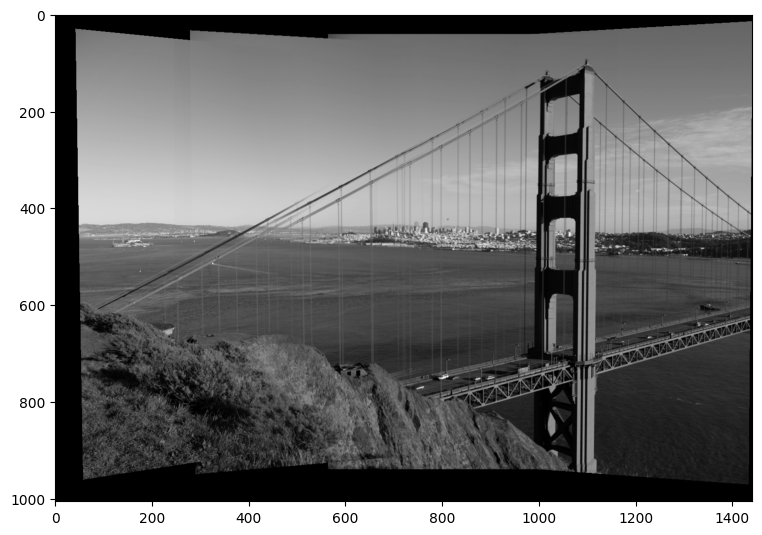

In [19]:
H, inlier_corr, inlier_dist = fit_homography(img3, mosaic012)
mosaic0123 = stitch(img3, mosaic012, H)
fig, axis = plt.subplots(figsize=(9,16))
axis.imshow(mosaic0123, cmap='gray');

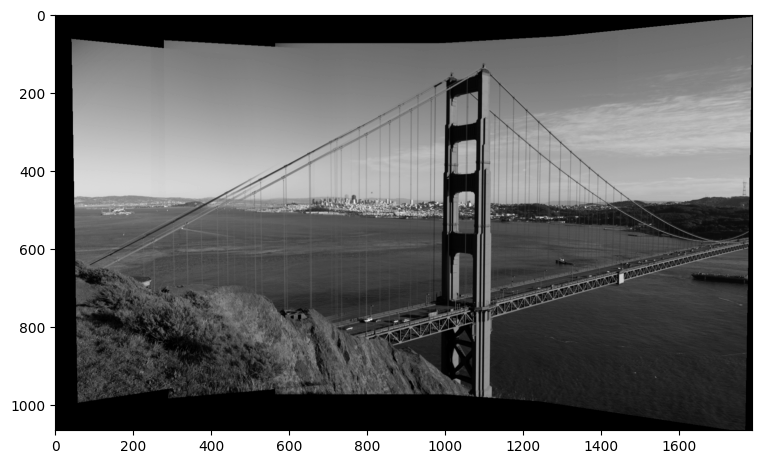

In [20]:
H, inlier_corr, inlier_dist = fit_homography(img4, mosaic0123)
mosaic0_4 = stitch(img4, mosaic0123, H)
fig, axis = plt.subplots(figsize=(9,16))
axis.imshow(mosaic0_4, cmap='gray');

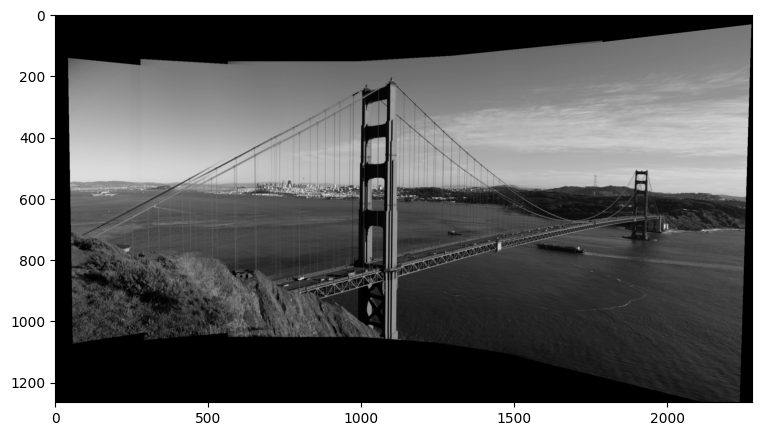

In [21]:
H, inlier_corr, inlier_dist = fit_homography(img5, mosaic0_4)
mosaic0_5 = stitch(img5, mosaic0_4, H)
fig, axis = plt.subplots(figsize=(9,16))
axis.imshow(mosaic0_5, cmap='gray');

In [22]:
cv2.imwrite('mosaic0_5.png', mosaic0_5)

True